In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

In [10]:
spark = SparkSession.builder.appName("Python Spark K-means").getOrCreate()

In [11]:
df = spark.read.csv("datasets\iris.csv", header = True, inferSchema = True, nullValue = 'NA')

In [12]:
df.show(5,True)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



In [13]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [14]:
df = df.na.drop()

In [15]:
df.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [16]:
assemble=VectorAssembler(inputCols=[
 'sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width'], outputCol='features')

In [17]:
assembled_data=assemble.transform(df)

In [19]:
assembled_data.show(5)

+------------+-----------+------------+-----------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|
+------------+-----------+------------+-----------+-----------+-----------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-----------+-----------------+
only showing top 5 rows



In [20]:
scale=StandardScaler(inputCol='features',outputCol='standardized')

In [21]:
data_scale=scale.fit(assembled_data)

In [22]:
data_scale_output=data_scale.transform(assembled_data)

In [24]:
data_scale_output.show(2)

+------------+-----------+------------+-----------+-----------+-----------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|        standardized|
+------------+-----------+------------+-----------+-----------+-----------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|[6.15892840883878...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|[5.9174018045706,...|
+------------+-----------+------------+-----------+-----------+-----------------+--------------------+
only showing top 2 rows



In [25]:
silhouette_score=[]

In [26]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

In [28]:
for i in range(2,8):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:", score, " K is: ", str(i))

Silhouette Score: 0.7714149126311811  K is:  2
Silhouette Score: 0.6435633372614079  K is:  3
Silhouette Score: 0.5699683135611282  K is:  4
Silhouette Score: 0.5588475451151954  K is:  5
Silhouette Score: 0.4854031919898742  K is:  6
Silhouette Score: 0.4610850243154621  K is:  7


ValueError: x and y must have same first dimension, but have shapes (6,) and (12,)

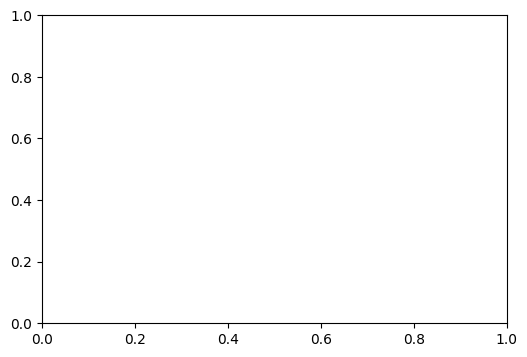

In [30]:
fig, ax = plt.subplots(1,1, figsize =(6,4))
ax.plot(range(2,8),silhouette_score)
ax.set_xlabel('K')
ax.set_ylabel('value')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [31]:
kmeans = KMeans().setK(2).setFeaturesCol("features").setPredictionCol("Cluster")
pipeline = Pipeline(stages=[kmeans])
model = pipeline.fit(assembled_data)
cluster = model.transform(assembled_data)

In [32]:
cluster.show(10,True)

+------------+-----------+------------+-----------+-----------+-----------------+-------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|Cluster|
+------------+-----------+------------+-----------+-----------+-----------------+-------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|      1|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|      1|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|      1|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|      1|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|      1|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|[5.4,3.9,1.7,0.4]|      1|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|[4.6,3.4,1.4,0.3]|      1|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|[5.0,3.4,1.5,0.2]|      1|
|         

In [34]:
df2 = cluster.drop('features')
df2.show(100,True)

+------------+-----------+------------+-----------+---------------+-------+
|sepal_length|sepal_width|petal_length|petal_width|        species|Cluster|
+------------+-----------+------------+-----------+---------------+-------+
|         5.1|        3.5|         1.4|        0.2|    Iris-setosa|      1|
|         4.9|        3.0|         1.4|        0.2|    Iris-setosa|      1|
|         4.7|        3.2|         1.3|        0.2|    Iris-setosa|      1|
|         4.6|        3.1|         1.5|        0.2|    Iris-setosa|      1|
|         5.0|        3.6|         1.4|        0.2|    Iris-setosa|      1|
|         5.4|        3.9|         1.7|        0.4|    Iris-setosa|      1|
|         4.6|        3.4|         1.4|        0.3|    Iris-setosa|      1|
|         5.0|        3.4|         1.5|        0.2|    Iris-setosa|      1|
|         4.4|        2.9|         1.4|        0.2|    Iris-setosa|      1|
|         4.9|        3.1|         1.5|        0.1|    Iris-setosa|      1|
|         5.